## Clean IRS by ZIP Code Data

This notebook cleans the IRS by ZIP data which was obtained from [the IRS's webpage](#https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi). The files from the IRS are stored in the folder scr/data/irs_zip and this notebook will save the cleaned data to scr/data/cleaned_irs_zip. This note book proceeds as follows.

1. First, we combine the excel files from the IRS into a single dataframe which has columns corresponding to year, zip code, size of adjusted gross income, and the total adjusted gross income (of the ZIP code).

2. We do some exploratory data analysis on the data that we have.

3. We add a column for county which we can determine from the ZIP code. We also add a column for borough which we can infer from county. 

4. Lastly, we save this to a csv file.

In [50]:
import pandas as pd 
from pathlib import Path
import re

In [51]:
data_dir = Path(r"../data/irs_zip") 

In [52]:
KEEP_BINS = { "$1 under $25,000", "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
}

# the following code extacts zip code, adjusted AGI, and corresponding size of AGI from the excel files

def extract_zip_bracket_agi(excel_path, year=None, sheet_name=0):
    engine = "xlrd" if str(excel_path).lower().endswith(".xls") else "openpyxl"
    raw = pd.read_excel(excel_path, sheet_name=sheet_name, header=None, engine=engine)

    header_row = None
    for i in range(min(150, len(raw))):
        c0 = "" if pd.isna(raw.iloc[i, 0]) else str(raw.iloc[i, 0]).lower()
        c1 = "" if raw.shape[1] < 2 or pd.isna(raw.iloc[i, 1]) else str(raw.iloc[i, 1]).lower()
        if ("zip" in c0 and "code" in c0) and ("size of adjusted gross income" in c1):
            header_row = i
            break
    if header_row is None:
        raise ValueError(f"Header row not found in {excel_path}")

    agi_col = None
    for j in range(raw.shape[1]):
        cell = raw.iloc[header_row, j]
        if isinstance(cell, str) and ("adjusted gross income" in cell.lower()) and ("agi" in cell.lower()):
            agi_col = j
            break
    if agi_col is None:
        raise ValueError(f"AGI column not found in {excel_path}")
    
    data_start = header_row + 3

    df = raw.iloc[data_start:, [0, 1, agi_col]].copy()
    df.columns = ["ZIP code [1]", "Size of adjusted gross income", "Adjusted gross income (AGI)"]
    df = df.dropna(how="all")

    df["ZIP code [1]"] = df["ZIP code [1]"].astype(str).str.strip()
    df = df[df["ZIP code [1]"].str.match(r"^\d{5}$|^0$", na=False)].copy()

    df["Size of adjusted gross income"] = df["Size of adjusted gross income"].astype(str).str.strip()
    df = df[df["Size of adjusted gross income"].isin(KEEP_BINS)].copy()

    df["Adjusted gross income (AGI)"] = pd.to_numeric(df["Adjusted gross income (AGI)"], errors="coerce")

    if year is not None:
        df.insert(0, "Year", year)

    return df.reset_index(drop=True)

In [53]:

all_frames = []

for f in sorted(list(data_dir.glob("*.xls")) + list(data_dir.glob("*.xlsx"))):
    name = f.name.lower()

    try:
        yy = int(name[2:4])
    except:
        print(f"Skipping (no leading year): {f.name}")
        continue

    if not (11 <= yy <= 22):
        continue
    year = 2000 + yy

    try:
        out = extract_zip_bracket_agi(f, year=year)
        all_frames.append(out)
        print(f"✓ {f.name}: {len(out):,} rows")
    except Exception as e:
        print(f"✗ {f.name}: {e}")

if all_frames:
    result = pd.concat(all_frames, ignore_index=True).sort_values(["Year", "ZIP code [1]", "Size of adjusted gross income"])
    result.to_csv(r"../data/cleaned_irs_zip/NY_2011_2022_ZIP_bracket_AGI.csv", index=False)
    print("\nSaved: NY_2011_2022_ZIP_bracket_AGI.csv")
else:
    print("No valid data extracted.")

✓ 2012_irs_NY_zip.xls: 9,282 rows
✓ 2013_irs_NY_zip.xls: 9,252 rows
✓ 2014_irs_NY_zip.xls: 9,264 rows
✓ 2015_irs_NY_zip.xls: 9,240 rows
✓ 2016_irs_NY_zip.xls: 9,246 rows
✓ 2017_irs_NY_zip.xlsx: 9,222 rows
✓ 2018_irs_NY_zip.xlsx: 9,216 rows
✓ 2019_irs_NY_zip.xlsx: 9,210 rows
✓ 2020_irs_NY_zip.xlsx: 9,234 rows
✓ 2021_irs_NY_zip.xlsx: 9,216 rows
✓ 2022_irs_NY_zip.xlsx: 9,222 rows

Saved: NY_2011_2022_ZIP_bracket_AGI.csv


In [54]:
result

,Year,ZIP code [1],Size of adjusted gross income,Adjusted gross income (AGI)
0,2012,0,"$1 under $25,000",43871428
4,2012,0,"$100,000 under $200,000",145291944
5,2012,0,"$200,000 or more",304729704
1,2012,0,"$25,000 under $50,000",75284440
2,2012,0,"$50,000 under $75,000",74930754
...,...,...,...,...
101602,2022,99999,"$100,000 under $200,000",1918767
101603,2022,99999,"$200,000 or more",18977340
101599,2022,99999,"$25,000 under $50,000",566215
101600,2022,99999,"$50,000 under $75,000",664620


In [55]:
## Loading and Cleaning Data for EDA 
import pandas as pd
import matplotlib.pyplot as plt
result = pd.read_csv(r"../data/cleaned_irs_zip/NY_2011_2022_ZIP_bracket_AGI.csv")

# Clean data: Remove statewide aggregate (0) and invalid ZIP codes
original_shape = result.shape
result = result[result["ZIP code [1]"].astype(str).str.strip() != "0"]
result = result[result["ZIP code [1]"].astype(str).str.strip() != "99999"]
print(f"Data cleaning:")
print(f"  Original shape: {original_shape}")
print(f"  Cleaned shape: {result.shape}")
print(f"  Unique ZIP codes: {result['ZIP code [1]'].nunique()}")

Data cleaning:
  Original shape: (101604, 4)
  Cleaned shape: (101472, 4)
  Unique ZIP codes: 1553


In [56]:
result.head(4)

,Year,ZIP code [1],Size of adjusted gross income,Adjusted gross income (AGI)
6,2012,10001,"$1 under $25,000",46886
7,2012,10001,"$100,000 under $200,000",282904
8,2012,10001,"$200,000 or more",1275646
9,2012,10001,"$25,000 under $50,000",93346


In [57]:
# This code isn't functioning

# ## Exploratory Data Analysis (EDA)

# df = result.copy()

# # Using 2011 as an example year to plot statewide distribution by bracket
# year = 2011
# df_year = df[df["Year"] == year]

# # Sum AGI by bracket (statewide including 00000)
# state = df_year.groupby("Size of adjusted gross income")["Adjusted gross income (AGI)"].sum()

# plt.figure()
# state.sort_values().plot(kind="barh")
# plt.title(f"NY Income Distribution by Bracket ({year})")
# plt.xlabel("Total AGI")
# plt.ylabel("Income Bracket")
# plt.show()

In [58]:
# This code isn't functioning

# ## Share of Income by Bracket (Statewide)
# state_total = df_year["Adjusted gross income (AGI)"].sum()
# share = (state / state_total) * 100


# plt.figure()
# share.sort_values().plot(kind="barh")
# plt.title(f"NY Income Share by Bracket (%) - {year}")
# plt.xlabel("Percent of Total AGI")
# plt.show()

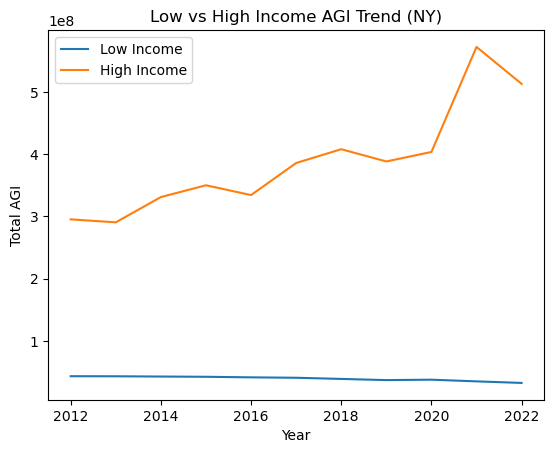

In [59]:
## Low income earner vs high income earner comparison (Statewide)
df = result.copy()

low = df[df["Size of adjusted gross income"] == "$1 under $25,000"]
high = df[df["Size of adjusted gross income"] == "$200,000 or more"]

low_trend = low.groupby("Year")["Adjusted gross income (AGI)"].sum()
high_trend = high.groupby("Year")["Adjusted gross income (AGI)"].sum()

plt.figure()
plt.plot(low_trend.index, low_trend.values)
plt.plot(high_trend.index, high_trend.values)
plt.title("Low vs High Income AGI Trend (NY)")
plt.xlabel("Year")
plt.ylabel("Total AGI")
plt.legend(["Low Income", "High Income"])
plt.show()

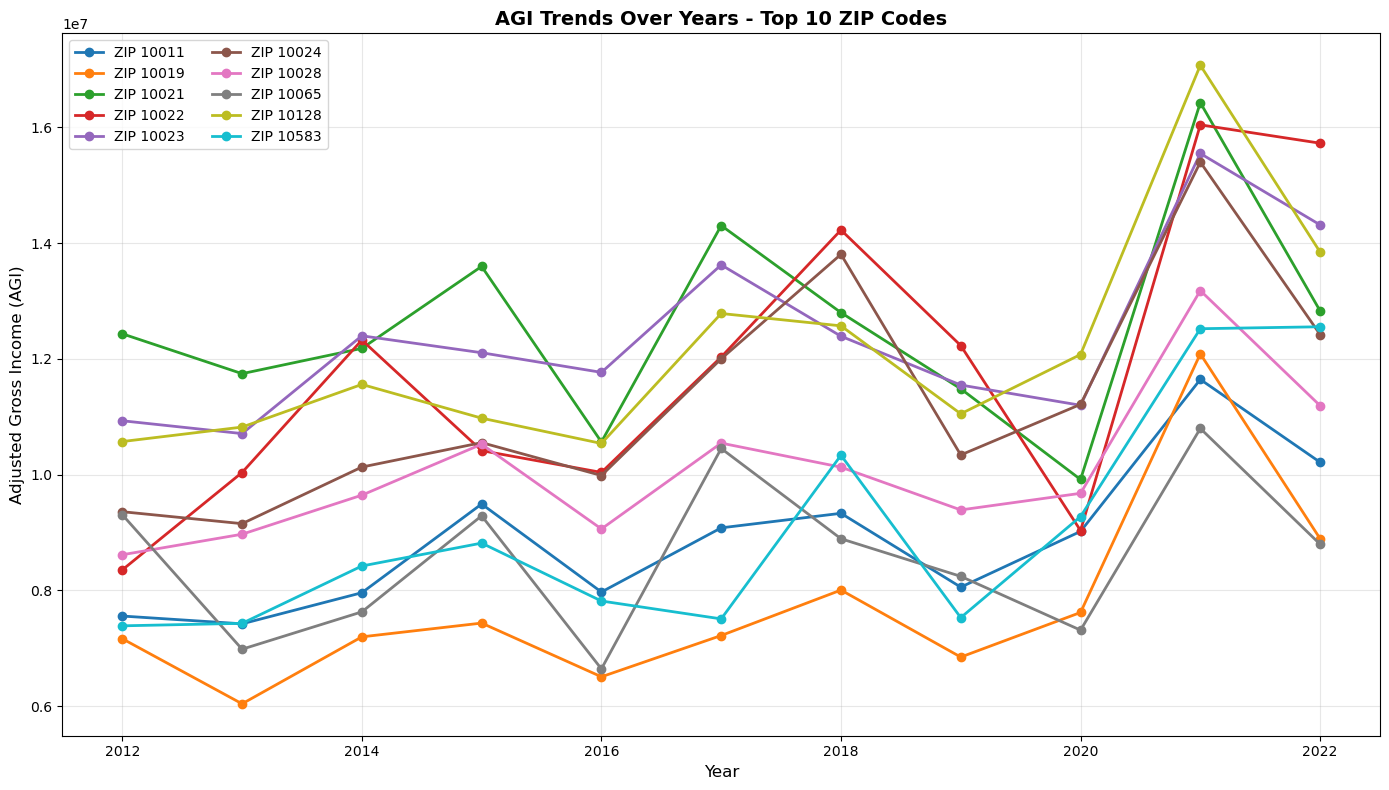

In [60]:
## Zone Code vs AGI Trend Over Years (Top 10 ZIP Codes)
top_zips_list = df.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().nlargest(10).index.tolist()

df_pivot = df[df["ZIP code [1]"].isin(top_zips_list)].groupby(
    ["Year", "ZIP code [1]"]
)["Adjusted gross income (AGI)"].sum().reset_index()

fig, ax = plt.subplots(figsize=(14, 8))

for zip_code in sorted(top_zips_list):
    zip_data = df_pivot[df_pivot["ZIP code [1]"] == zip_code].sort_values("Year")
    ax.plot(zip_data["Year"], zip_data["Adjusted gross income (AGI)"], marker='o', label=f"ZIP {zip_code}", linewidth=2)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Adjusted Gross Income (AGI)", fontsize=12)
ax.set_title("AGI Trends Over Years - Top 10 ZIP Codes", fontsize=14, fontweight='bold')
ax.legend(loc='best', ncol=2, fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


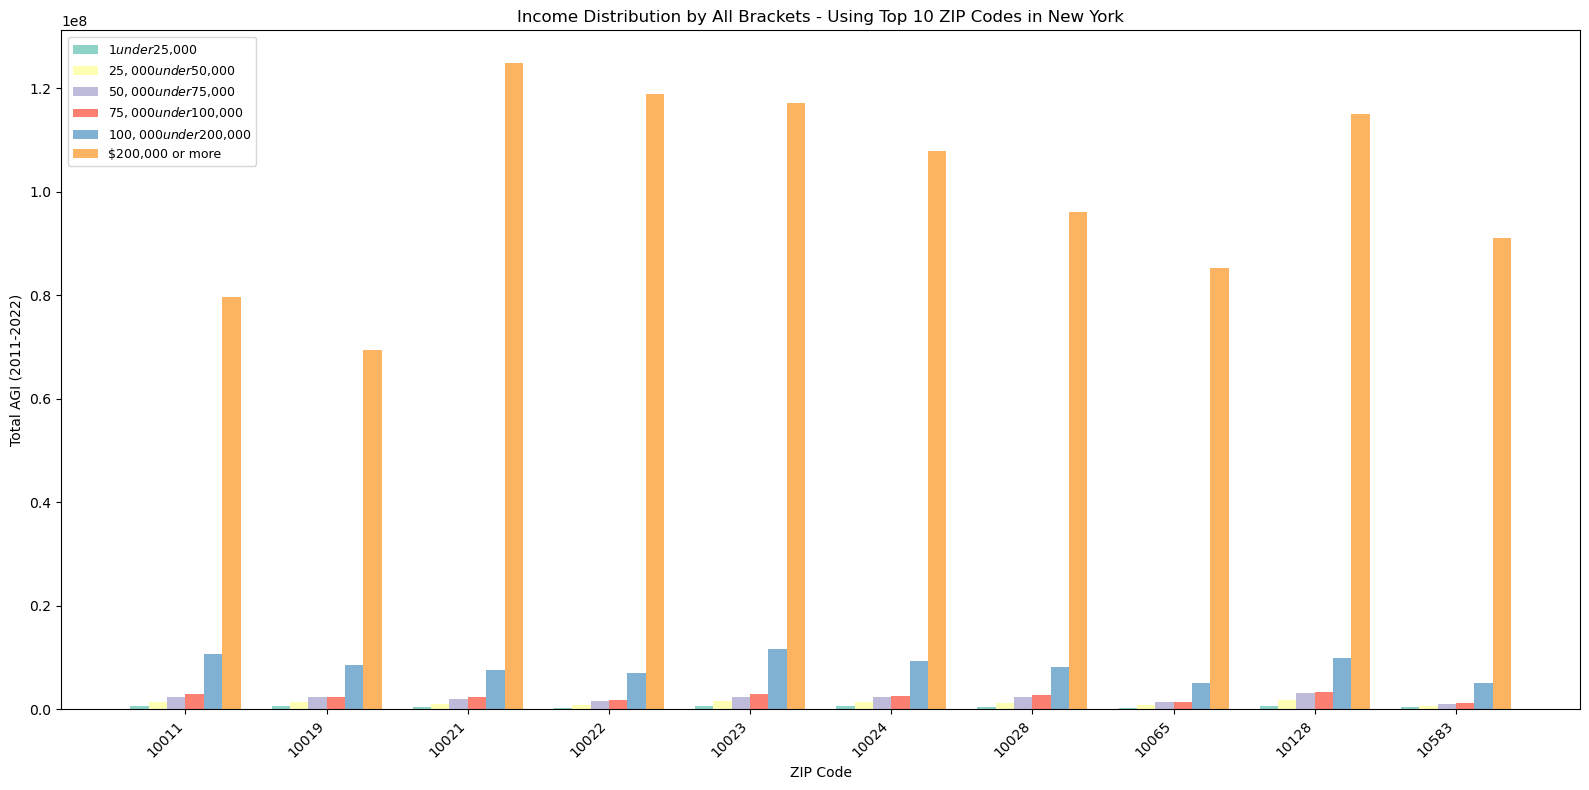

In [61]:
## Low vs High Income by All Brackets - Side by Side for Top ZIP Codes
top_zips_overall = df.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().nlargest(10).index.tolist()

pivot_data = df[df["ZIP code [1]"].isin(top_zips_overall)].groupby(
    ["ZIP code [1]", "Size of adjusted gross income"]
)["Adjusted gross income (AGI)"].sum().unstack(fill_value=0)

bracket_order = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]
pivot_data = pivot_data[[col for col in bracket_order if col in pivot_data.columns]]

fig, ax = plt.subplots(figsize=(16, 8))
x = range(len(pivot_data))
width = 0.13 
colors = plt.cm.Set3(range(len(pivot_data.columns)))

for i, bracket in enumerate(pivot_data.columns):
    offset = (i - len(pivot_data.columns) / 2) * width + width / 2
    ax.bar([p + offset for p in x], pivot_data[bracket].values, width, label=bracket, color=colors[i])

ax.set_xlabel("ZIP Code")
ax.set_ylabel("Total AGI (2011-2022)")
ax.set_title("Income Distribution by All Brackets - Using Top 10 ZIP Codes in New York")
ax.set_xticks(x)
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
ax.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


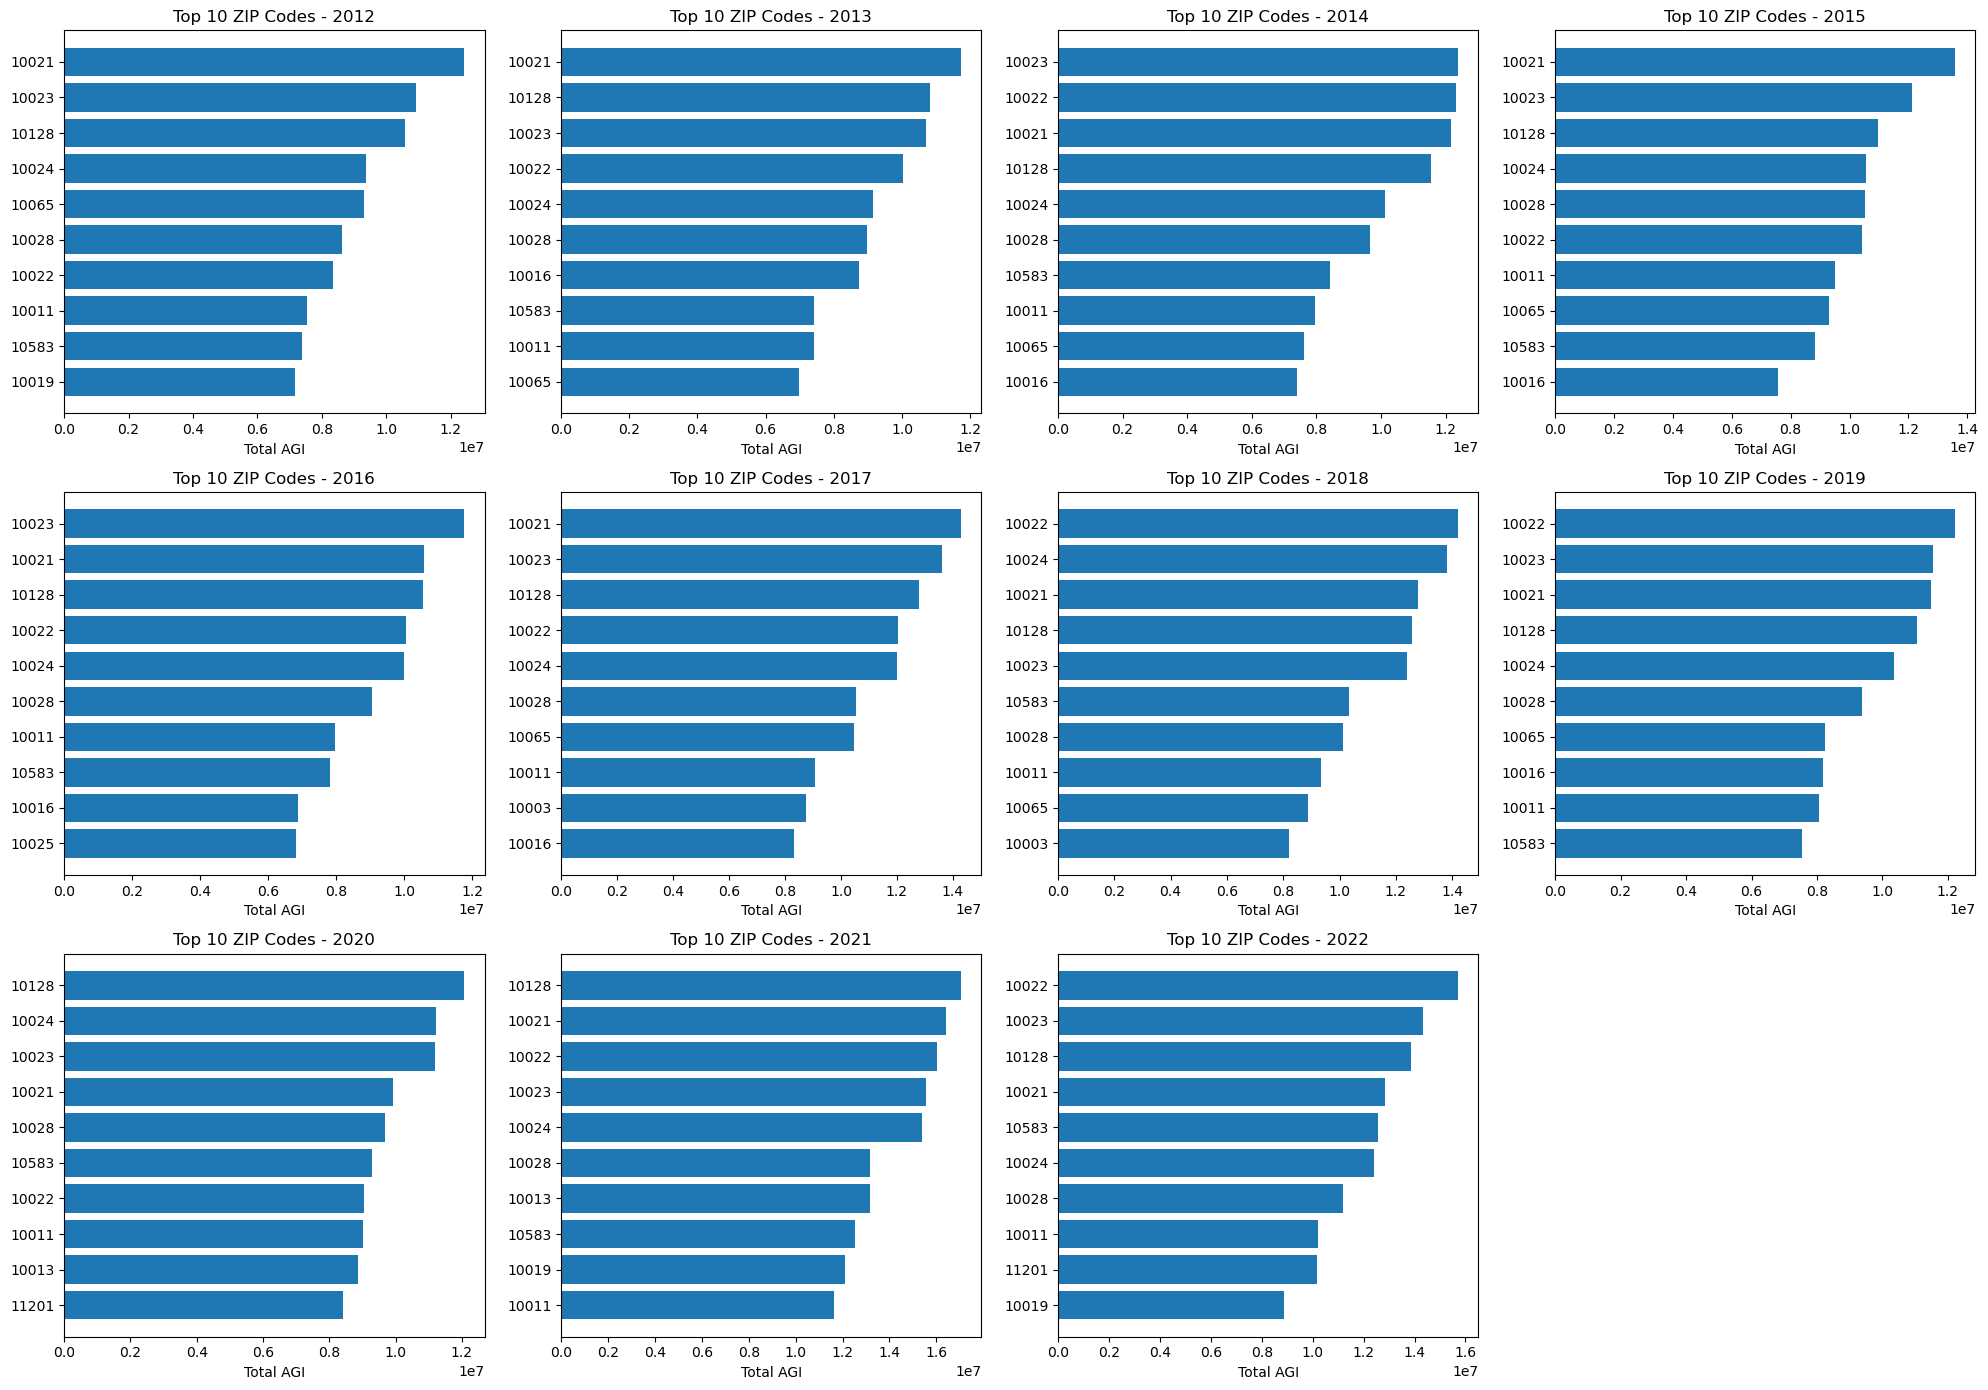

In [62]:
# Zone Code (ZIP) vs AGI - Side by Side by Year
years = sorted(df['Year'].unique())
n_years = len(years)
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
axes = axes.flatten()

for idx, year in enumerate(years):
    df_year = df[df['Year'] == year]
    zip_agi_year = df_year.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().sort_values(ascending=False)
    top_zips = zip_agi_year.head(10)
    axes[idx].barh(range(len(top_zips)), top_zips.values)
    axes[idx].set_yticks(range(len(top_zips)))
    axes[idx].set_yticklabels(top_zips.index)
    axes[idx].set_xlabel("Total AGI")
    axes[idx].set_title(f"Top 10 ZIP Codes - {year}")
    axes[idx].invert_yaxis()

for idx in range(len(years), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [63]:
## ZIP Code to County/Region Mapping
def map_zip_to_county(zip_code):
    """Map NY ZIP codes to counties/regions"""
    try:
        zip_int = int(zip_code)
    except:
        return "Other"
    
    # NYC Boroughs
    if 10001 <= zip_int <= 10299:
        return "Manhattan"
    elif 11200 <= zip_int <= 11299:
        return "Brooklyn"
    elif 11350 <= zip_int <= 11435:
        return "Queens"
    elif 10450 <= zip_int <= 10475:
        return "Bronx"
    elif 10300 <= zip_int <= 10314:
        return "Staten Island"
    # Westchester County
    elif 10501 <= zip_int <= 10977:
        return "Westchester"
    # Nassau County (Long Island)
    elif 11501 <= zip_int <= 11589:
        return "Nassau"
    # Suffolk County (Long Island)
    elif 11700 <= zip_int <= 11976:
        return "Suffolk"
    # Rockland County
    elif 10901 <= zip_int <= 10989:
        return "Rockland"
    # Orange County
    elif 10910 <= zip_int <= 10989:
        return "Orange"
    # Dutchess County
    elif 12514 <= zip_int <= 12601:
        return "Dutchess"
    else:
        return "Other"

# Adding the county column to dataframe
df_county = df.copy()
df_county["County"] = df_county["ZIP code [1]"].apply(map_zip_to_county)

result['county'] = result['ZIP code [1]'].apply(map_zip_to_county)
# Getting major counties
major_counties = df_county[df_county["County"] != "Other"].groupby("County")["Adjusted gross income (AGI)"].sum().nlargest(6).index

print("Major Counties in Data:")
print(df_county[df_county["County"] != "Other"].groupby("County")["Adjusted gross income (AGI)"].sum().sort_values(ascending=False))


Major Counties in Data:
County
Manhattan        2122278809
Westchester      1108470814
Suffolk          1069147428
Brooklyn          849448265
Queens            540887624
Nassau            432235667
Bronx             284606933
Dutchess          186697272
Staten Island     180002719
Rockland           21951493
Name: Adjusted gross income (AGI), dtype: int64


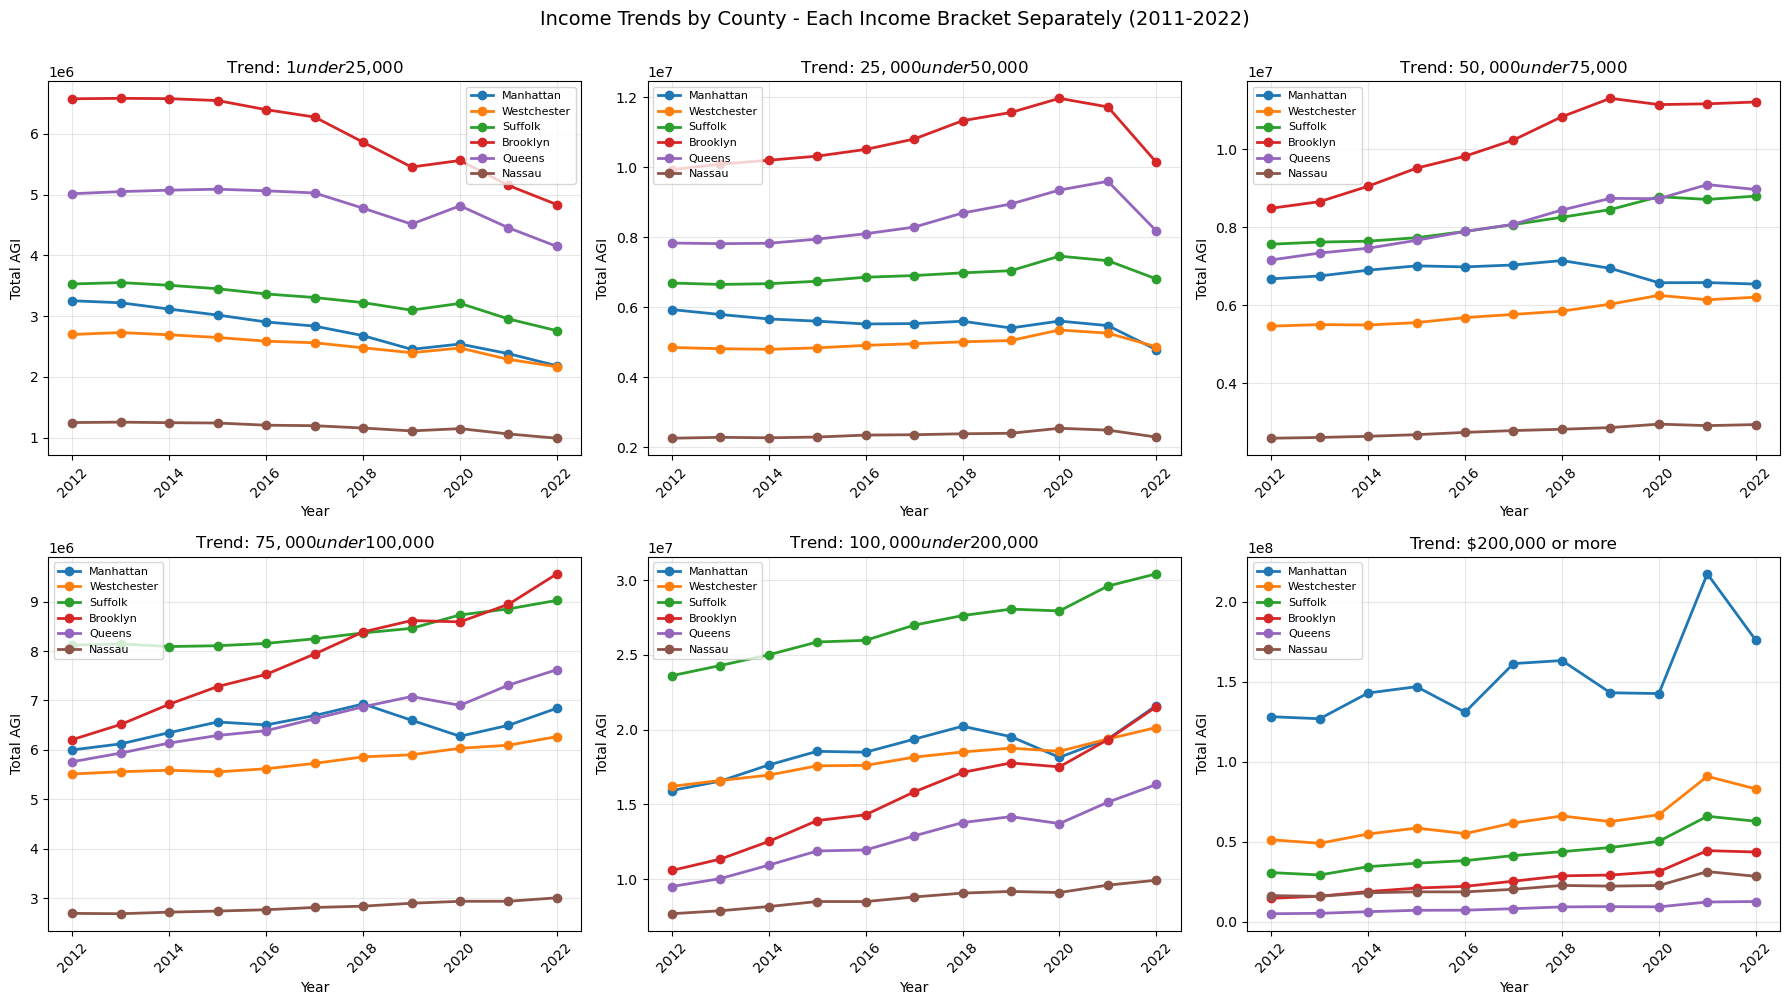

In [64]:
## Income Bracket Trends by County (All Brackets)
bracket_order = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]

# Creating subplots for each income bracket
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = plt.cm.tab10(range(len(major_counties)))

for idx, bracket in enumerate(bracket_order):
    ax = axes[idx]
    bracket_data = df_county[df_county["Size of adjusted gross income"] == bracket]
    
    for color_idx, county in enumerate(major_counties):
        county_data = bracket_data[bracket_data["County"] == county].groupby("Year")["Adjusted gross income (AGI)"].sum()
        if not county_data.empty:
            ax.plot(county_data.index, county_data.values, marker='o', label=county, color=colors[color_idx], linewidth=2)
    
    ax.set_xlabel("Year")
    ax.set_ylabel("Total AGI")
    ax.set_title(f"Trend: {bracket}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Income Trends by County - Each Income Bracket Separately (2011-2022)", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


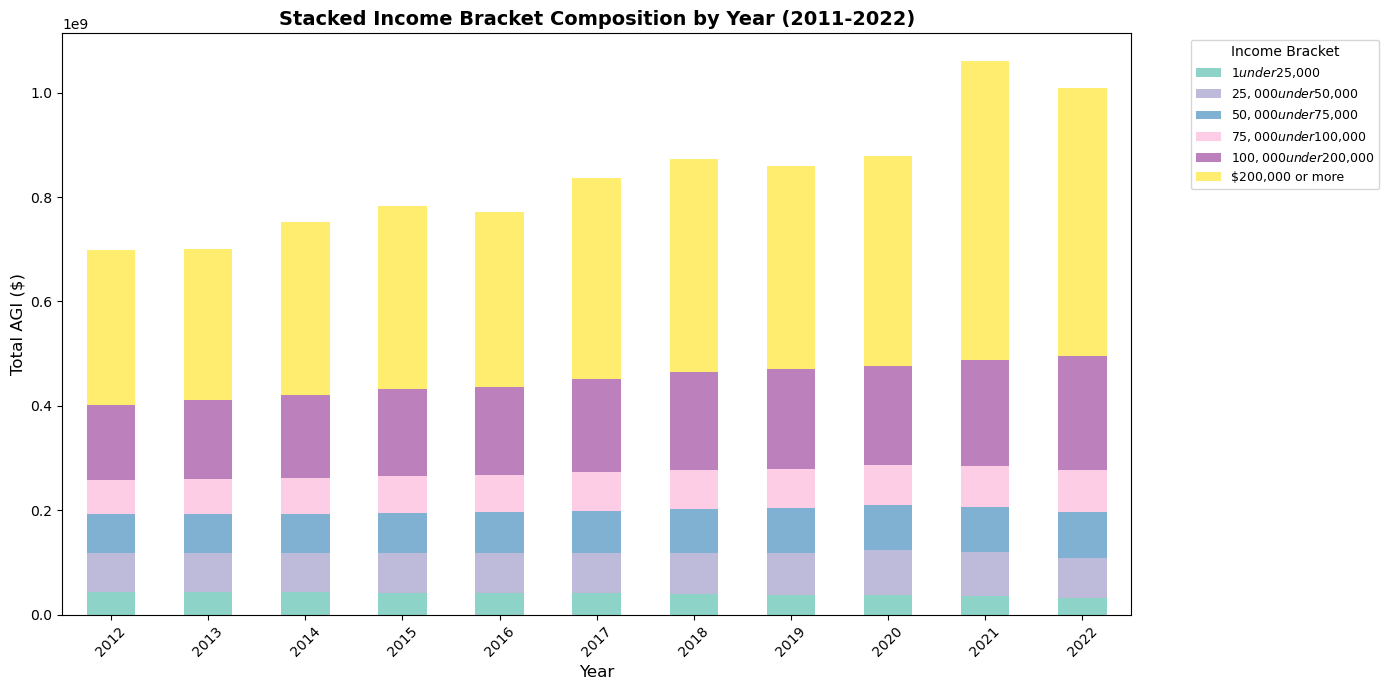

In [65]:
## Income Bracket Composition by Year
bracket_order = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]

bracket_by_year = df.groupby(["Year", "Size of adjusted gross income"])["Adjusted gross income (AGI)"].sum().unstack(fill_value=0)
bracket_by_year = bracket_by_year[[col for col in bracket_order if col in bracket_by_year.columns]]

# stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))
bracket_by_year.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Total AGI ($)", fontsize=12)
ax.set_title("Stacked Income Bracket Composition by Year (2011-2022)", fontsize=14, fontweight='bold')
ax.legend(title="Income Bracket", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


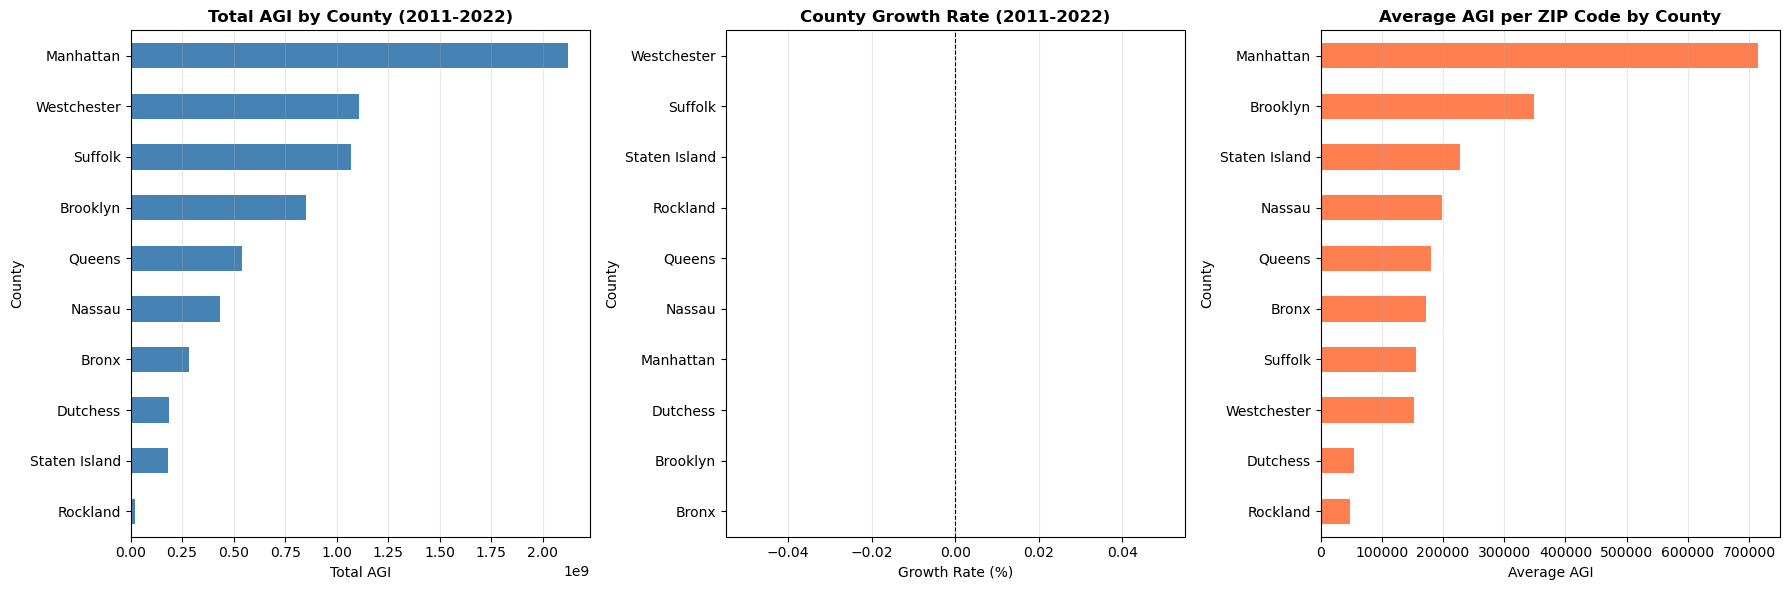


County Growth Summary (2011-2022):
  Bronx: +nan%
  Brooklyn: +nan%
  Dutchess: +nan%
  Manhattan: +nan%
  Nassau: +nan%
  Queens: +nan%
  Rockland: +nan%
  Staten Island: +nan%
  Suffolk: +nan%
  Westchester: +nan%


In [66]:
## 3. County Comparison Charts
county_totals = df_county.groupby("County")["Adjusted gross income (AGI)"].sum().sort_values(ascending=True)
county_totals = county_totals[county_totals.index != "Other"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# County Totals
county_totals.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel("Total AGI")
axes[0].set_title("Total AGI by County (2011-2022)", fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# County Growth Rate (2011 vs 2022)
df_2011 = df_county[df_county["Year"] == 2011].groupby("County")["Adjusted gross income (AGI)"].sum()
df_2022 = df_county[df_county["Year"] == 2022].groupby("County")["Adjusted gross income (AGI)"].sum()
growth_rate = ((df_2022 - df_2011) / df_2011 * 100).sort_values(ascending=True)
growth_rate = growth_rate[growth_rate.index != "Other"]

colors = ['red' if x < 0 else 'green' for x in growth_rate]
growth_rate.plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_xlabel("Growth Rate (%)")
axes[1].set_title("County Growth Rate (2011-2022)", fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

# Average AGI per County
avg_agi = df_county.groupby("County")["Adjusted gross income (AGI)"].mean().sort_values(ascending=True)
avg_agi = avg_agi[avg_agi.index != "Other"]

avg_agi.plot(kind='barh', ax=axes[2], color='coral')
axes[2].set_xlabel("Average AGI")
axes[2].set_title("Average AGI per ZIP Code by County", fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCounty Growth Summary (2011-2022):")
for county, rate in growth_rate.items():
    print(f"  {county}: {rate:+.1f}%")


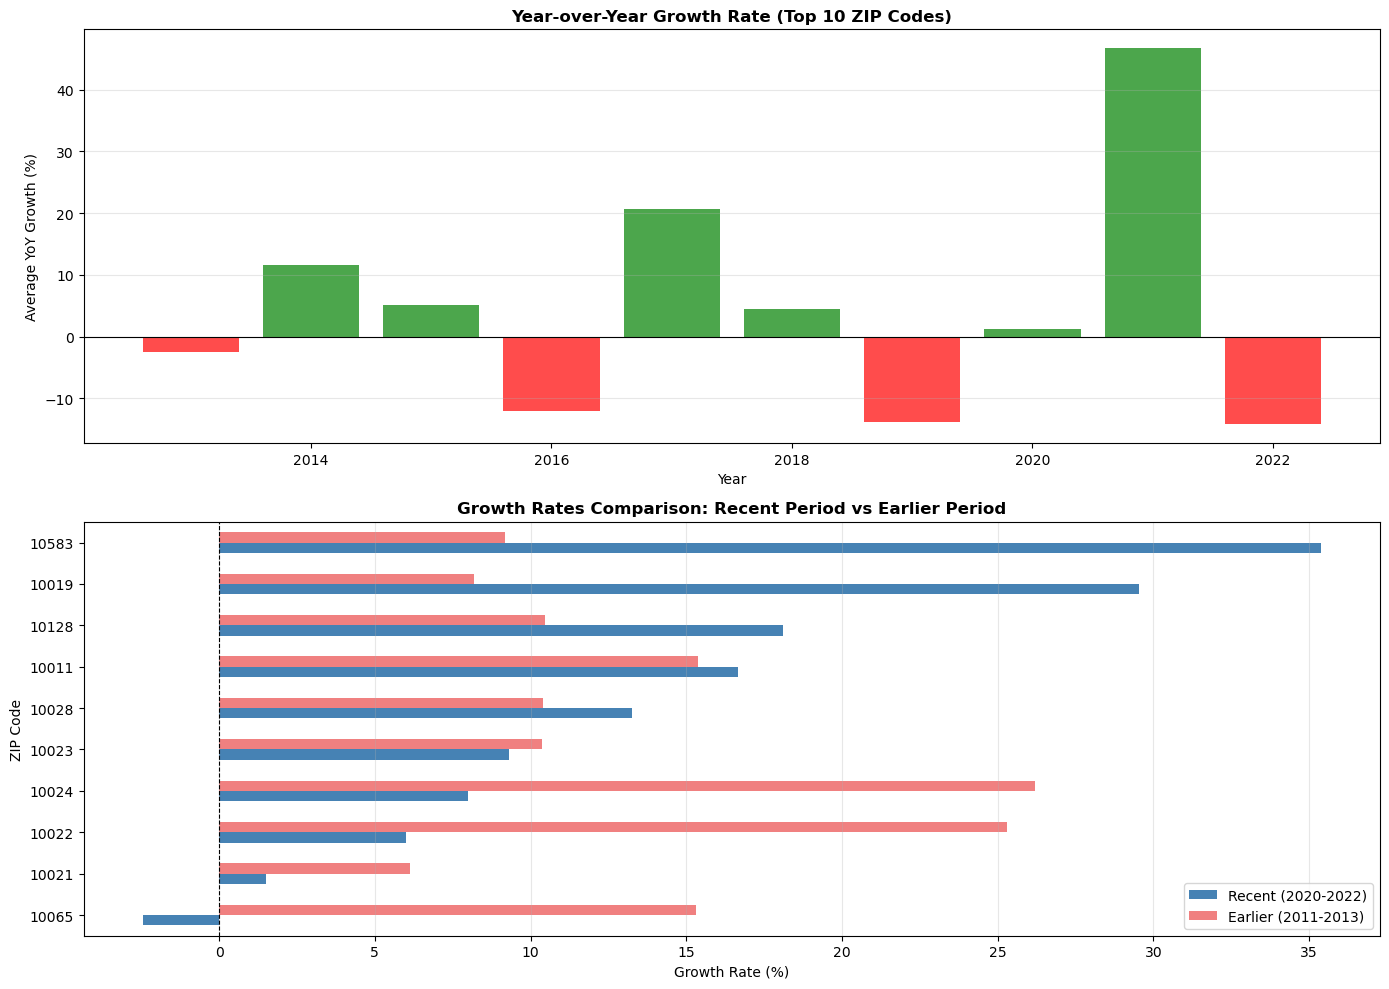

In [67]:
## Year-over-Year Growth Rates
top_10_zips = df.groupby("ZIP code [1]")["Adjusted gross income (AGI)"].sum().nlargest(10).index.tolist()

yoy_growth = []
for year in sorted(df['Year'].unique())[1:]:
    prev_year = year - 1
    
    df_prev = df[df['Year'] == prev_year].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
    df_curr = df[df['Year'] == year].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
    
    growth = ((df_curr - df_prev) / df_prev * 100).fillna(0)
    yoy_growth.append({'Year': year, 'Growth_Rate': growth[growth.index.isin(top_10_zips)].mean()})

yoy_df = pd.DataFrame(yoy_growth)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# YoY Growth Rate Trend
colors = ['green' if x > 0 else 'red' for x in yoy_df['Growth_Rate']]
axes[0].bar(yoy_df['Year'], yoy_df['Growth_Rate'], color=colors, alpha=0.7)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Average YoY Growth (%)")
axes[0].set_title("Year-over-Year Growth Rate (Top 10 ZIP Codes)", fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Growth Rate by Top 10 ZIPs (Latest 3 Years vs Previous 3 Years)
recent_years = sorted(df['Year'].unique())[-3:]
earlier_years = sorted(df['Year'].unique())[-6:-3]

df_recent = df[df['Year'].isin(recent_years)].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
df_earlier = df[df['Year'].isin(earlier_years)].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()

growth_comparison = pd.DataFrame({
    'Recent (2020-2022)': ((df_recent - df_earlier) / df_earlier * 100).fillna(0),
    'Earlier (2017-2019)': 0
})

# Calculating the actual growth for earlier period
df_earliest = df[df['Year'].isin(sorted(df['Year'].unique())[:3])].groupby('ZIP code [1]')['Adjusted gross income (AGI)'].sum()
growth_comparison['Earlier (2011-2013)'] = ((df_earlier - df_earliest) / df_earliest * 100).fillna(0)

growth_comparison = growth_comparison[growth_comparison.index.isin(top_10_zips)].sort_values('Recent (2020-2022)', ascending=True)

growth_comparison[['Recent (2020-2022)', 'Earlier (2011-2013)']].plot(kind='barh', ax=axes[1], color=['steelblue', 'lightcoral'])
axes[1].set_xlabel("Growth Rate (%)")
axes[1].set_ylabel("ZIP Code")
axes[1].set_title("Growth Rates Comparison: Recent Period vs Earlier Period", fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()


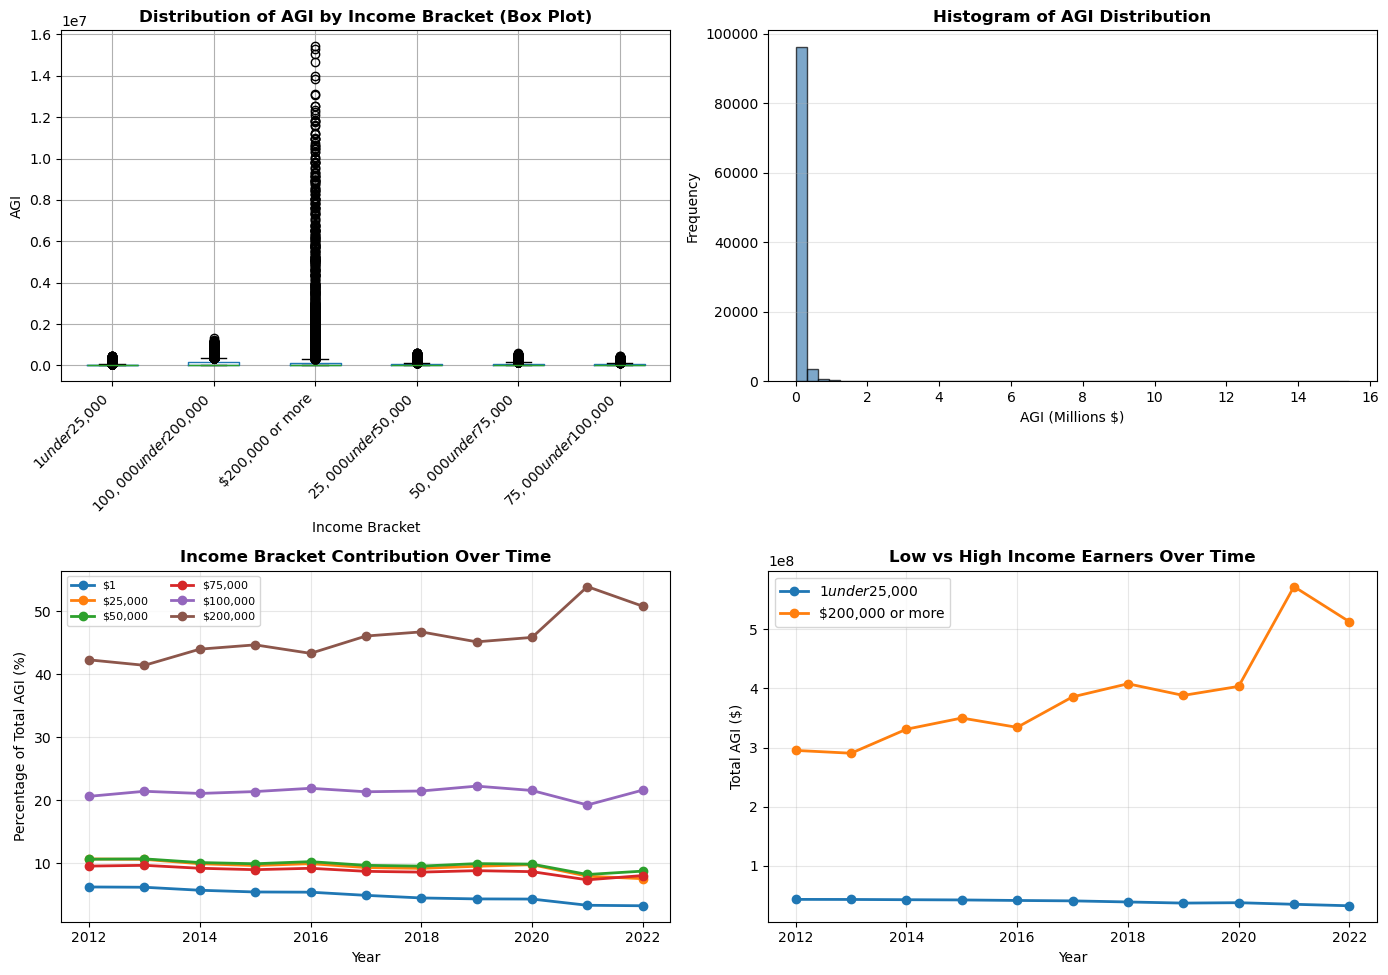

In [68]:
## Distribution Plots - Income Bracket Analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Box Plot of AGI by Income Bracket
df.boxplot(column='Adjusted gross income (AGI)', by='Size of adjusted gross income', ax=axes[0, 0])
axes[0, 0].set_xlabel("Income Bracket")
axes[0, 0].set_ylabel("AGI")
axes[0, 0].set_title("Distribution of AGI by Income Bracket (Box Plot)", fontweight='bold')
fig.suptitle('')
plt.sca(axes[0, 0])
plt.xticks(rotation=45, ha='right')

# Histogram of AGI values
axes[0, 1].hist(df['Adjusted gross income (AGI)'] / 1e6, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel("AGI (Millions $)")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Histogram of AGI Distribution", fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Bracket contribution percentage over time
bracket_pct = df.groupby(['Year', 'Size of adjusted gross income'])['Adjusted gross income (AGI)'].sum().unstack(fill_value=0)
bracket_pct_normalized = bracket_pct.div(bracket_pct.sum(axis=1), axis=0) * 100

bracket_list = [
    "$1 under $25,000",
    "$25,000 under $50,000",
    "$50,000 under $75,000",
    "$75,000 under $100,000",
    "$100,000 under $200,000",
    "$200,000 or more",
]

for bracket in bracket_list:
    if bracket in bracket_pct_normalized.columns:
        axes[1, 0].plot(bracket_pct_normalized.index, bracket_pct_normalized[bracket], marker='o', label=bracket.split()[0], linewidth=2)

axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Percentage of Total AGI (%)")
axes[1, 0].set_title("Income Bracket Contribution Over Time", fontweight='bold')
axes[1, 0].legend(fontsize=8, loc='best', ncol=2)
axes[1, 0].grid(True, alpha=0.3)

# Top brackets trend
top_brackets = ['$1 under $25,000', '$200,000 or more']
for bracket in top_brackets:
    bracket_trend = df[df['Size of adjusted gross income'] == bracket].groupby('Year')['Adjusted gross income (AGI)'].sum()
    axes[1, 1].plot(bracket_trend.index, bracket_trend.values, marker='o', label=bracket, linewidth=2, markersize=6)

axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Total AGI ($)")
axes[1, 1].set_title("Low vs High Income Earners Over Time", fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [69]:
result['county'].value_counts()

county
Other            70380
Westchester       7296
Suffolk           6864
Dutchess          3432
Queens            3006
Manhattan         2970
Brooklyn          2442
Nassau            2178
Bronx             1650
Staten Island      792
Rockland           462
Name: count, dtype: int64

In [70]:
def county_to_borough(county):
    if county in ["Manhattan", "Brooklyn", "Queens", "Bronx", "Staten Island"]:
        return county
    else:
        return "Other"

result['borough'] = result['county'].apply(county_to_borough)


In [71]:
result.columns 

Index(['Year', 'ZIP code [1]', 'Size of adjusted gross income',
       'Adjusted gross income (AGI)', 'county', 'borough'],
      dtype='str')

In [73]:
display(result.head(5))
result.to_csv(r"../data/cleaned_irs_zip/cleaned_2011_2022_ZIP_AGI.csv", index=False)
print("\nSaved: cleaned_2011_2022_ZIP_AGI.csv")

,Year,ZIP code [1],Size of adjusted gross income,Adjusted gross income (AGI),county,borough
6,2012,10001,"$1 under $25,000",46886,Manhattan,Manhattan
7,2012,10001,"$100,000 under $200,000",282904,Manhattan,Manhattan
8,2012,10001,"$200,000 or more",1275646,Manhattan,Manhattan
9,2012,10001,"$25,000 under $50,000",93346,Manhattan,Manhattan
10,2012,10001,"$50,000 under $75,000",110732,Manhattan,Manhattan



Saved: cleaned_2011_2022_ZIP_AGI.csv
